# `swift_too` module

## Swift_ObsQuery example - querying past *Swift* observations

### API version = 1.2

#### Author: Jamie A. Kennea (Penn State)

The Swift_ObsQuery class allows for querying the database of observations have have already been performed by Swift, otherwise known as the "As-Flown Science Timeline" (AFST). Note this will only fetch observations that have already been performed, not scheduled observations. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from swifttools.swift_too import Swift_ObsQuery
from time import sleep
import numpy as np

### Constructing the query

Set up the class, giving our username and shared secret. These can be set up [on the Swift TOO website](https://www.swift.psu.edu/toop/too.php). After you log in, you will find your shared secret, and can modify it as necessary under the [Update Account Info](https://www.swift.psu.edu/toop/account_info.php) link. 

In [2]:
username = 'myuser'
shared_secret = 'mysharedsecret'

In [3]:
query = Swift_ObsQuery()
query.username = username
query.shared_secret = shared_secret

First example, how often has Swift observed the binary system SS 433? Well, I can't remember the RA/Dec off the top of my head, so let's look it up on Simbad.

In [4]:
target_name = "SS 433"
from astroquery.simbad import Simbad
table = Simbad.query_object(target_name)

Convert this Simbad obtained RA/Dec into an Astropy SkyCoord

In [5]:
from astropy.coordinates import SkyCoord
import astropy.units as u

query.skycoord = SkyCoord(f"{table['RA'][0]} {table['DEC'][0]}",frame="icrs",unit=(u.hourangle, u.deg))


RA/Dec is stored by the TOO API in decimal degrees, in J2000 epoch as this is the epoch Swift uses

In [6]:
print(f"RA/Dec(J2000) = {query.ra:.4f}, {query.dec:.4f}")

RA/Dec(J2000) = 287.9565, 4.9827


Looks legit. However, we can also set RA/Dec the old fashioned way which doesn't require Simbad or astropy

In [7]:
query.ra, query.dec = 287.9565, 4.9827

Note that if you already defined a skycoord, it will remain correct even if you changed the ra and dec properties.

In [8]:
query.skycoord

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (287.9565, 4.9827)>


Swift_ObsQuery has a default search radius which is....

In [9]:
print(f"Default search radius = {query.radius:.3f} degrees")

Default search radius = 0.197 degrees


That's 12 arcminutes, which is the approximate field of view of Swift's X-ray Telescope (XRT). We can narrow that down a bit, so we only get matches that are in the center of the field of view (FOV), and also in UVOT which has a smaller FOV.

In [10]:
query.radius = 5 / 60 # 5 arc-minutes, as the units for radius are degrees

### Submitting the query 

OK let's query the Swift timeline to see how many observations it's taken. This might take a few seconds to process. Note that there are two ways you can submit a job. You can either queue it up, then check periodically if the job is complete, then if it is, continue. Here is some example code of doing that.

In [11]:
if query.queue():
    while(not query.complete):
        print(f"Waiting for job #{query.status.jobnumber} to be processed ...")
        sleep(2)
    print(f"Done. Job #{query.status.jobnumber} complete")
else:
    print(f"Request rejected. Error: {query.status.errors}")

Done. Job #47727 complete


Or you can let the TOO_API code handle the timeout. Note that the default timeout is set to 120, but you can set it longer if you like, using e.g. query.submit(timeout=300). Note: You can still run the code below if you ran the previous entry, if the query is completed, it will just return back as True.


In [12]:
if query.submit():
    print("Success!")
else:
    print(f"Fail or timeout? {query.status}")

Success!


### Examining the results of the query

So how many observations has Swift taken of this target?

In [13]:
print(f"This many: {len(query)}")

This many: 77


That's a lot of damage. Here's a thing to remember, every entry in this is a single snapshot of observation. As Swift is in a low Earth orbit, it means that a snapshot is typically max 30 mins, or sometimes a bit longer (~44 mins), so a long exposure will consist of multiple snapshots. Observations are grouped by obsid (a 12 digit number with leading zeros), so snapshots with the same obsid are part of the same planned observation.

In [14]:
query

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2005-07-30 13:23:02,2005-07-30 13:27:00,SS433,00035190001,95,143
2005-07-30 13:27:02,2005-07-30 13:30:48,SS433,00035190002,210,16
2005-08-01 13:36:02,2005-08-01 13:40:00,SS433,00035190005,95,143
2005-08-01 13:40:02,2005-08-01 13:56:58,SS433,00035190006,1000,16
2005-08-01 18:44:15,2005-08-01 18:46:32,SS433,00035190007,0,137
2005-08-01 18:46:35,2005-08-01 19:08:01,SS433,00035190008,1270,16
2005-08-18 00:59:02,2005-08-18 01:14:58,SS433,00035190013,870,86
2005-08-18 02:35:02,2005-08-18 02:51:58,SS433,00035190013,930,86
2006-06-30 13:45:02,2006-06-30 13:55:00,SS 433,00035190014,425,173
2006-06-30 15:19:02,2006-06-30 15:31:00,SS 433,00035190014,545,173


Wow that is a lot of observations. 

### Pointing Accuracy

Here's an interesting thing about Swift, it doesn't point very accurately. This is because the ACS system sacrifices accuracy for speed. The goal is to get the object of interest into the field of view of XRT and UVOT, not at the boresight. As a result, the pointing direction be typically up to 3 arcminutes off the requested pointing direction. Note that for each entry listed above, we give an ra and dec value, so let's check out the variation:

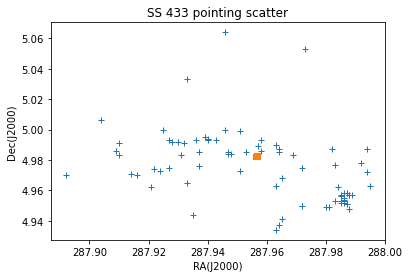

In [15]:
plt.figure()
plt.plot([float(entry.ra) for entry in query],[float(entry.dec) for entry in query],"+")
plt.plot([entry.ra_point for entry in query],[entry.dec_point for entry in query],"X")
plt.xlabel("RA(J2000)")
plt.ylabel("Dec(J2000)")
_= plt.title(f"{target_name} pointing scatter")

As you can see there's a lot of variation of the pointing direction. Each entry also has a values ra_point, dec_point, which give the decimal degrees values of the requested pointing direction for each observation. This typically will be the coordinates of the Target of the Observation, but sometimes if offsets are applied for any reason, it might differ.

The ra_point/dec_point values aren't necessarily going to be for the object you queried on. In fact there can be multiple values of ra_point/dec_point if the queried field lies inside multiple pointings.

Although the RA/Dec are returned in J2000 decimal degrees, it's pretty easy to convert these into SkyCoords for you astropy fans. As the swift_too module doesn't require astropy as a depency, you can do it with some simple codeas follows:

In [16]:
sc = SkyCoord([entry.ra for entry in query],[entry.dec for entry in query],frame='fk5',unit=(u.deg,u.deg))

However, sometimes ra_point, dec_point cannot be determined, so the value will be 'None'. I'm going to filter those out so we can do some comparing.

In [17]:
sc = SkyCoord([entry.ra for entry in query if entry.ra_point != None],[entry.dec for entry in query if entry.ra_point != None],frame='fk5',unit=(u.deg,u.deg))
scp = SkyCoord([entry.ra_point for entry in query  if entry.ra_point != None],[entry.dec_point for entry in query  if entry.ra_point != None],frame='fk5',unit=(u.deg,u.deg))

I made an array of ra_point/dec_point so we can evaluate how accurately Swift actually pointed at this target. Let's make a histogram of the pointing offsets.

Median offset value = 2.17 arc-minutes


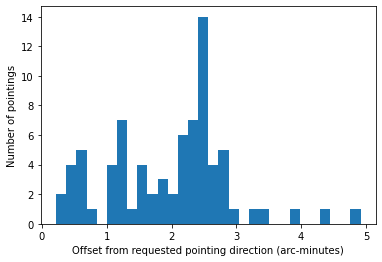

In [18]:
plt.figure()
plt.hist(sc.separation(scp).arcmin,bins=30)
plt.ylabel("Number of pointings")
plt.xlabel("Offset from requested pointing direction (arc-minutes)")
print(f"Median offset value = {np.median(sc.separation(scp).arcmin):0.2f} arc-minutes")

So you'll see that the median offset here is around 2 arc-minutes, with a pretty big scatter, and there may even be some large outliers. 


### Grouping Snapshots into Observations 

Let's take a look at an individual entry to see what information is being returned by this query.

In [19]:
query[0].api_data

{'begin': '2005-07-30 13:23:02',
 'settle': '2005-07-30 13:25:25',
 'end': '2005-07-30 13:27:00',
 'ra': 287.994,
 'dec': 4.972,
 'roll': 317.225,
 'targname': 'SS433',
 'targetid': 35190,
 'seg': 1,
 'ra_point': 287.9565,
 'dec_point': 4.982667,
 'xrt': 'Auto',
 'uvot': '0x000a',
 'bat': 0,
 'fom': 50,
 'obstype': 'PPT'}

So some useful information here. Firstly remember each entry represents a snapshot of Swift data, that is data taken in a single orbit of observations. Typically data that you obtain from the SDC will be grouped by observation, and those observations can contain many snapshots. Observations have a unique target ID (target ID) and segment (seg) numbers. These typically are combined into a Observation ID (obsnum), which in the SDC format will look like a concatibation of the target ID, and segment, with padding zeros, e.g.:

In [20]:
print(f"Target ID = {query[0].targetid}, segment = {query[0].seg}, ObservationID = {query[0].obsnum}")

Target ID = 35190, segment = 1, ObservationID = 00035190001


If you're interested in all the observations under a particular Observation ID, then there's a property called "observations" that contains a dictionary of all observations on an Observation ID basis. Let's look at the summary of this dictionary by just printing out all the entries.

In [21]:
query.observations

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2005-07-30 13:23:02,2005-07-30 13:27:00,SS433,00035190001,95,143
2005-07-30 13:27:02,2005-07-30 13:30:48,SS433,00035190002,210,16
2005-08-01 13:36:02,2005-08-01 13:40:00,SS433,00035190005,95,143
2005-08-01 13:40:02,2005-08-01 13:56:58,SS433,00035190006,1000,16
2005-08-01 18:44:15,2005-08-01 18:46:32,SS433,00035190007,0,137
2005-08-01 18:46:35,2005-08-01 19:08:01,SS433,00035190008,1270,16
2005-08-18 00:59:02,2005-08-18 02:51:58,SS433,00035190013,1800,172
2006-06-30 13:45:02,2006-06-30 23:27:00,SS 433,00035190014,3275,1212
2006-07-01 02:34:02,2006-07-02 10:53:56,SS 433,00035190015,7830,2600
2006-11-03 18:42:58,2006-11-03 22:20:08,SS433,00035190016,5016,715


You can see that now the summary shows the details for an entire observation, with the begin and end times being those of associated with the first and last observation of that Observation ID, and the exposure time being the total. Importantly due to orbit gaps, the exposure time is not just end minus begin. Each entry in the observations dictionary contains details on the individual segments also. Note that Observation ID is a string, given as it is formatted with padding zeros. For example:

In [22]:
query.observations['00035190015']

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2006-07-01 02:34:02,2006-07-02 10:53:56,SS 433,00035190015,7830,2600


If we want to see what snapshots make up a particular observation, it's easy:

In [23]:
query.observations['00035190015'].snapshots

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2006-07-01 02:34:02,2006-07-01 02:43:56,SS 433,00035190015,435,159
2006-07-01 04:11:02,2006-07-01 04:24:56,SS 433,00035190015,675,159
2006-07-01 05:47:02,2006-07-01 05:59:01,SS 433,00035190015,560,159
2006-07-01 07:24:02,2006-07-01 07:34:58,SS 433,00035190015,485,171
2006-07-01 09:00:02,2006-07-01 09:11:57,SS 433,00035190015,535,180
2006-07-01 10:36:02,2006-07-01 10:47:57,SS 433,00035190015,535,180
2006-07-01 12:13:02,2006-07-01 12:23:58,SS 433,00035190015,485,171
2006-07-01 20:15:02,2006-07-01 20:25:58,SS 433,00035190015,475,181
2006-07-01 21:51:02,2006-07-01 22:02:57,SS 433,00035190015,535,180
2006-07-02 02:41:02,2006-07-02 02:50:58,SS 433,00035190015,415,181


You can query the exposure and other infomation for the combined snapshots in the Observation ID.

In [24]:
query.observations['00035190015'].exposure

datetime.timedelta(seconds=7830)

Note that the result here is a datetime timedelta object. You can easily get the seconds as an integer or convert to an astropy TimeDelta object.

In [25]:
query.observations['00035190015'].exposure.seconds

7830

In [26]:
from astropy.time import TimeDelta
TimeDelta(query.observations['00035190015'].exposure)

<TimeDelta object: scale='None' format='datetime' value=2:10:30>

Note that there is no RA/Dec (ra/dec) for an observation, only the requested pointing direction (ra_point/dec_point), because actual RA/Dec will be different for each snapshot, so delve into the individual snapshots for those. 

In [27]:
query.observations['00035190015'].ra_point, query.observations['00035190015'].dec_point

(287.9565, 4.982667)

# Instrument Configuration 

All observations for a given Observation ID will have the same instrument configuration. Let's check those out.

In [28]:
print(f"XRT mode = {query.observations['00035190015'].xrt}, UVOT mode = {query.observations['00035190015'].uvot}")

XRT mode = Auto, UVOT mode = 0x20ed


In this case the XRT mode is `Auto`, which means that XRT itself decides whether to be in PC or WT mode, based on the brightness of sources in the central 200x200 pixels of the detector, roughly the central 8.5 arcmin x 8.5 arcmin box. Because of this we can't determine what mode XRT will have actually taken the data in without looking at it. However for many observation, the mode is fixed, here you will see results like so:

In [29]:
print(f"XRT mode = {query.observations['00035190037'].xrt}")

XRT mode = PC


As this is PC mode, we can guarantee that the data are taken in PC mode.

For UVOT the mode above is a hex number `0x20ed`. There are a large number of modes that can be used with UVOT, given it's many different combinations of filters, exposure windows, etc. Luckily you can query what this mode means using the `UVOT_mode` class. We can quickly display a table showing details of the mode as follows:

In [30]:
from swifttools.swift_too import UVOT_mode
UVOT_mode(username,shared_secret,query.observations['00035190015'].uvot)

Filter,Event FOV,Image FOV,Bin Size,Max. Exp. Time,Weighting,Comments
uvw1,None,17,2,540,1500,BLUE WEIGHTING
u,None,17,2,270,750,BLUE WEIGHTING
b,None,17,2,270,750,BLUE WEIGHTING
uvw2,17,None,None,None,3000,BLUE WEIGHTING
v,None,17,2,270,750,BLUE WEIGHTING
uvm2,17,None,None,None,2250,BLUE WEIGHTING


Finally: It's also important to remember that a specific UVOT mode does not guarantee data was taken with the expected filters, so always check the data.

# Querying by Time
If instead of querying by position or target, you are interested in querying the *Swift* AFST by time of observation, for instance if you want to know where *Swift* was pointed at a given time, this can also be easily done (most of the time). You just define pass `begin` for your given time, without specifying `end`. `begin` should either be in `datetime` format, e.g. 

In [31]:
from datetime import datetime
#define your time of interest
timestamp = datetime(2021,4,19,13,35,27)

or you can just specify the timestamp in ISO format as a string, e.g.

In [32]:
timestamp = '2021-04-19 13:35:27'

You can even use an `astropy` `Time` class if you like, which is handy if you want to use time formats other than regular UT. Note that `swift_too` does not depend on `astropy`, so it returns values in datetime format.

In [33]:
from astropy.time import Time
timestamp = Time(59323.56629,format='mjd')

...noting that timestamps are in UT timezone.

In [34]:
query = Swift_ObsQuery(username,
                     shared_secret,
                     begin=timestamp)

In [35]:
if query.status.status == 'Accepted':
    print("All Good!")
else:
    print(f"Not good: {query.status}")

All Good!


Ok, what did we get?

In [36]:
query

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2021-04-19 13:34:02,2021-04-19 13:46:56,MCG+8-11-11,00095943204,605,169


A single observation, that was performed during our time of interest, as expected. Show me the deets!

In [37]:
print(f'Swift pointing RA, Dec, Roll: {query[0].ra, query[0].dec, query[0].roll}')

Swift pointing RA, Dec, Roll: (88.648, 46.428, 264.157)


But wait! This is the *settled* pointing, if your time of interest happens to be during the slew to this object, then these pointing coordinates are *not* valid.

In [38]:
if timestamp > query[0].settle:
    print('Good to go!')
else:
    print(f'Swift was slewing during your time of interest. \nTo get pointing information for this time, \
consult the attitude file associated with obsid {query[0].obsnum}.')

Swift was slewing during your time of interest. 
To get pointing information for this time, consult the attitude file associated with obsid 00095943204.


*Swift* is slewing ~15% of the time, so most of the time this method will quickly get you the answer you want.

You can of course query over a range of times, simply by specifying the `end` parameter, so:

In [39]:
query = Swift_ObsQuery(username,
                     shared_secret,
                     begin=timestamp,end=Time(59323.56629+0.1,format='mjd'))

In [40]:
query

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2021-04-19 13:34:02,2021-04-19 13:46:56,MCG+8-11-11,00095943204,605,169
2021-04-19 13:47:01,2021-04-19 14:08:58,NGC4945 X-1,00013908014,1105,212
2021-04-19 14:09:02,2021-04-19 14:23:00,WASP-94a,00013289109,710,128
2021-04-19 14:23:02,2021-04-19 14:35:00,RX J2217.9-5941,00095912001,655,63
2021-04-19 14:35:02,2021-04-19 14:53:57,saa-cold-109-07,00076301008,1060,75
2021-04-19 14:54:01,2021-04-19 15:00:48,,01044032002,315,92
2021-04-19 15:00:50,2021-04-19 15:04:00,FAIRALL 1116,00095839002,125,65
2021-04-19 15:04:02,2021-04-19 15:14:00,SN2021iyt,00014264003,450,148
2021-04-19 15:14:02,2021-04-19 15:33:57,MRK 817,00096066019,1065,130
2021-04-19 15:34:02,2021-04-19 15:50:01,ZTF20achpcvt,00013976010,890,69


# Querying by Target ID and Observation Number

Target ID is the number assigned to a specific target, so if you have that number and you want to see how often a target with that target ID has been observation, you can specify it in the search. Note that some targets have mulitple target IDs assigned to them, so we always recommend doing an RA/Dec search if you want to know about all the observations that have been taken.

In [41]:
query = Swift_ObsQuery(username,
                     shared_secret,
                     targetid=35000)

In [42]:
query

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2005-06-09 17:53:02,2005-06-09 18:11:01,1ES 0120+340,00035000001,955,124
2005-06-09 19:28:02,2005-06-09 19:47:59,1ES 0120+340,00035000001,990,207
2006-07-06 08:47:02,2006-07-06 09:01:59,1ES 0120+340,00035000002,825,72
2006-07-06 10:23:02,2006-07-06 10:37:57,1ES 0120+340,00035000002,825,70
2006-07-06 11:57:02,2006-07-06 12:08:59,1ES 0120+340,00035000002,560,157
2006-07-06 13:34:02,2006-07-06 13:45:59,1ES 0120+340,00035000002,560,157
2006-07-06 15:10:02,2006-07-06 15:21:59,1ES 0120+340,00035000002,560,157
2006-07-06 16:47:02,2006-07-06 17:01:59,1ES 0120+340,00035000002,740,157
2006-07-06 18:23:02,2006-07-06 18:37:59,1ES 0120+340,00035000002,740,157
2006-07-06 19:59:02,2006-07-06 20:13:59,1ES 0120+340,00035000002,740,157


You can also query by Observation Number. This number comes in two formats, the SDC format, which is always a 11 character long string consisting of the target ID (8 characters) and segment (3 characters) with leading zeros. So for a target ID 35000 and segment 7, the SDC format is `00035000007`. The other format is the one used by Swift itself, in which the observation number is a 32-bit word, in which the target ID is the lower three bytes, and the segment number is the highest significance byte. Here's a demonstration of how this works:

In [43]:
targetid = 35000
segment = 7
obsnum = f"{targetid:08}{segment:03}"
obsnumsc = targetid + (segment << 24)
print(f"SDC format: {obsnum} Swift format: {obsnumsc}")

SDC format: 00035000007 Swift format: 117475512


Either can be used, but if the SDC format is desired, it must be passed as a string.

In [44]:
Swift_ObsQuery(username,shared_secret,obsnum='00035000007')

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2007-09-12 18:47:01,2007-09-12 18:56:56,1ES0120+340,00035000007,525,70


In [45]:
Swift_ObsQuery(username,shared_secret,obsnum=117475512)

Begin,End,Name,Obs Number,Exposure (s),Slewtime (s)
2007-09-12 18:47:01,2007-09-12 18:56:56,1ES0120+340,00035000007,525,70


Note that the TOO API internally utilizes the Swift format, but transparanently converts it for you.

In [46]:
obsq = Swift_ObsQuery()
obsq.obsnum = '00035000007'
print(f"obsnum = {obsq.obsnum}")

obsnum = 117475512
